****This notebook contains the code to evaluate within subject cross session gradient peak locations.****


****It also creates peak ROIs for distance measurements to the rest of the cortex****

Import libraries

In [1]:
import numpy as np 
import nibabel as nib 

import nilearn.plotting
import matplotlib.pyplot as plt
import mayavi
from mayavi import mlab
import ptitprince as pt
import seaborn as sn
import pandas as pd
import numba
from utils import *

import networkx as nx
import gdist
import surfdist as sd 
import surfdist.analysis  

from sklearn.cluster import KMeans

from IPython.display import display, HTML
import matplotlib.offsetbox as offsetbox
!jupyter nbextension enable mayavi --user --py
mlab.init_notebook('png',150,150)

/Users/austin/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


Enabling notebook extension mayavi/x3d/x3dom...
      - Validating: OK
Notebook initialized with png backend.


In [2]:
subjects=!ls -d *10*/
for i in range(len(subjects)):
    subjects[i]=subjects[i].split('/')[0]
#### load watersheds
LWS=nib.load('/Users/austin/Documents/ParisHorizontal/Mai2022Grads/watershedTemplates/LWS.28.max.label.gii').darrays[0].data
RWS=nib.load('/Users/austin/Documents/ParisHorizontal/Mai2022Grads/watershedTemplates/RWS.28.max.label.gii').darrays[0].data

**Define helper Functions**

In [3]:
def recort(X,fill,dims):
    out=np.zeros(dims)
    out[fill]=X
    return out

def recort_bin(X,fill,dims):
    out=np.zeros(dims)
    mini=np.zeros(len(fill))
    mini[X]=1
    out[fill]=mini
    return out
    

def binit(X):
    pct=np.percentile(X,[10,20,30,40,50,60,70,80,90])
    pct=np.digitize(X,pct)
    return pct+1 

def binit20(X):
    pct=np.percentile(X,[20,40,60,80])
    pct=np.digitize(X,pct)
    return pct+1 


def get_zoneVerts(WS):
    zoneverts={}
    for i in range(1,np.max(WS)):
        zoneverts.update({f'zone{i}':np.where(WS==i)[0]})
    return zoneverts

def oh_mayavi(surf,stat,cmap,clrbar=True):
    """surface, statmap, colormap"""
    ##### parse the gifti 
    anat=nib.load(surf)
    coords=anat.darrays[0].data
    x=coords[:,0]
    y=coords[:,1]
    z=coords[:,2]
    triangles=anat.darrays[1].data
    ##### if subcortical mask provided use it

#         print('masking out subcortex')
#     sub_cort=nilearn.surface.load_surf_data(args[0])
#     stat[sub_cort]=float('NaN')

    
    
    ### start mayavi 
    
    maya=mlab.triangular_mesh(x,y,z,triangles,scalars=stat,colormap=cmap)
    
    mlab.view(azimuth=0, elevation=-90)
    f = mlab.gcf()
    cam = f.scene.camera
    cam.zoom(1.)
    if clrbar==True:
        cb=mlab.colorbar(orientation='vertical', nb_labels=3,label_fmt='%.2f')
        cb.label_text_property.color =(0,0,0)
    else: 
        pass

    mlab.draw()
    

    img1=mlab.screenshot(figure=maya,mode='rgba',antialiased=True)
    mlab.view(azimuth=0, elevation=90)
    mlab.figure(bgcolor=(0, 0, 0))
    ### clear figure
    mayavi.mlab.clf()
    
    f = mlab.gcf()
    cam = f.scene.camera
    cam.zoom(1.1)
    mlab.draw()
    img2=mlab.screenshot(figure=maya,mode='rgba',antialiased=True)
    ### clear figure
    mayavi.mlab.clf()
    mlab.clf()
    mlab.close()
    return img1,img2


def plot_srfs(a,b,c,d,title=False):
    figure=plt.figure(figsize=(6, 8), dpi=180)
    plt.subplot(2,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.imshow(b)
    plt.axis('off')
    mlab.clf()
    plt.subplot(2,2,3)
    plt.imshow(c)
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(d)
    plt.axis('off')

    plt.subplots_adjust(left=0.1,
                        bottom=0.5, 
                        top=0.9, 
                        wspace=0, 
                        hspace=0)
    if title !=False:
        figure.suptitle(title, fontsize=16,y=0.5)
    
    plt.tight_layout()
#     plt.savefig(f'{file}.png',bbox_inches='tight',facecolor='w')
#     plt.close()


def SpatialNeighbours(coords,faces):
    #### gives the same output as mris_convert -v but directly into a python structure
    neighbours={}
    for i in range(len(coords)):
        a=np.unique(faces[np.where(faces==i)[0]])
        a=a[a!=i]
        neighbours[i]=a.tolist()
    return neighbours

def Zscore(x):
    Z=(x-np.mean(x))/np.std(x)
    return Z

def dice_it(A,B):
    
    num=2*(len(np.intersect1d(A,B)))
    den=len(A)+len(B)
    
    if den ==0:
        return np.nan
    else:
        return num/den

def jaccard_it(A,B):
    num=len(np.intersect1d(A,B))
    den=len(np.union1d(A,B))
    
    if den ==0:
        return 0
    else:
        return num/den

def gradientOrientation(grad,hemi,aparc):
    """Determine the orientation of the gradients, and also return whether valid for continued study or not"""
    grad=grad #nib.load(grad).agg_data()
    if hemi=='left':
        labels=nib.load(aparc).agg_data()
#       print('getting gradient orientation from left hemisphere')
    else:
        labels=nib.load(aparc).agg_data()
#       print('getting gradient orientation from right hemisphere')
    calc=np.where(labels==45)[0]
    ctr=np.where(labels==46)[0]
    if np.sum(grad[calc])<0 and np.sum(grad[ctr])<0:
#       print('Canonical Orientation DMN at apex')
        return grad,True
    elif np.sum(grad[calc])<0 and np.sum(grad[ctr])>0:
#       print(f'REMOVE {subj} FROM STUDY')
        return grad,False
    elif np.sum(grad[calc])>0 and np.sum(grad[ctr])<0:
#       print(f'REMOVE {subj} FROM STUDY')
        return grad,False
    else:
#       print('flipping gradient orientation for peak detection')
        return grad *-1,True
##### flatten a list
def flatten(l):
    return [item for sublist in l for item in sublist]

def prep_plotting(subj,kernel,sim='dice',pca=False):
    
    thr=[50,55,60,65,70,75,80,85,90,95]
    
    ctx_metric=[]
    zone_metricsL=[]
    zone_metricsR=[]
    
    if pca == False:
        gr=hcp_subj(subj,kernel)
        if gr.Lgradses1[1] == False or gr.Lgradses2[1] == False or gr.Rgradses1[1] ==False or gr.Rgradses2[1] ==False:
#             print(f'subject {gr.subj} Diffusion Mapping is not valid at smoothing kernel {kernel} ')
            return [gr.subj,kernel],[gr.subj,kernel],[gr.subj,kernel]
        else:
            if sim=='dice':
                for t in thr:
                    ctx_metric.append(gr.dice_Ses12(t))
                    zone_metricsL.append(gr.ZoneDice_Ses12(t)[0])
                    zone_metricsR.append(gr.ZoneDice_Ses12(t)[1])
            else: 
                for t in thr:
                    gr.Jaccard_Ses12(t)
                    ctx_metric.append(gr.Jaccard_Ses12(t))
                    zone_metricsL.append(gr.ZoneDice_Ses12(t)[0])
                    zone_metricsR.append(gr.ZoneDice_Ses12(t)[1])
                    
        
    else:
        gr=hcp_subj(subj,kernel,pca=True)
        if gr.Lgradses1[1] == False or gr.Lgradses2[1] == False or gr.Rgradses1[1] ==False or gr.Rgradses2[1] ==False:
#             print(f'subject {gr.subj} PCA is not valid at smoothing kernel {kernel} ')
            return [gr.subj,kernel],[gr.subj,kernel],[gr.subj,kernel]
        else:
            if sim=='dice':
                for t in thr:
                    ctx_metric.append(gr.dice_Ses12(t))
                    zone_metricsL.append(gr.ZoneDice_Ses12(t)[0])
                    zone_metricsR.append(gr.ZoneDice_Ses12(t)[1])
            else: 
                for t in thr:
                    gr.Jaccard_Ses12(t)
                    ctx_metric.append(gr.Jaccard_Ses12(t))
                    
                    zone_metricsL.append(gr.ZoneDice_Ses12(t)[0])
                    zone_metricsR.append(gr.ZoneDice_Ses12(t)[1])
                    
    return np.vstack(ctx_metric),np.vstack(zone_metricsL),np.vstack(zone_metricsR)


def prep_plotsXkernel(kernel,pca=False,corr=True):
    ### set up outputs
    Lhemi=[]
    Rhemi=[]
    LlatPar=[]
    LTmp=[]
    LmedPar=[]
    RlatPar=[]
    RTmp=[]
    RmedPar=[]
    
    nogo=[]
    
    ### loop through subjjects for specified kernel
    for subj in subjects:
        a,b,c=prep_plotting(subj,kernel,pca=pca)
        if len(a)>2:
            Lhemi.append(a[:,0])
            Rhemi.append(a[:,1])
        
            LlatPar.append(b[:,0])
            LTmp.append(b[:,1])
            LmedPar.append(b[:,2])
        
            RlatPar.append(c[:,0])
            RTmp.append(c[:,1])
            RmedPar.append(c[:,2])
        else:
            nogo.append(a[0])
    Lhemi=np.vstack(Lhemi)
    Rhemi=np.vstack(Rhemi)
    
    LlatPar=np.vstack(LlatPar)
    LTmp=np.vstack(LTmp)
    LmedPar=np.vstack(LmedPar)
    
    RlatPar=np.vstack(LlatPar)
    RTmp=np.vstack(LTmp)
    RmedPar=np.vstack(LmedPar)
    
    if corr == True:
        corr=(len(Lhemi)/len(subjects))
        return   (Lhemi*corr),(Rhemi*corr),(LlatPar*corr),(LTmp*corr),(LmedPar*corr),(RlatPar*corr),(RTmp*corr),(RmedPar*corr),nogo
    elif corr == False:
        return  Lhemi,Rhemi,LlatPar,LTmp,LmedPar,RlatPar,RTmp,RmedPar,nogo
    
def plot_itHue(k,rgn,legend=False,corr=True):
    """where k = kernel of 2,4,6,8,10 and rgn indexes the output of prep"""
    if corr==True:
        a=prep_plotsXkernel(k)
        b=prep_plotsXkernel(k,pca=True)
    elif corr==False:
        a=prep_plotsXkernel(k,corr=False)
        b=prep_plotsXkernel(k,pca=True,corr=False)

    a=pd.DataFrame.from_dict(dict(zip(thr,a[rgn].T)))
    a['Method']='Diffusion Mapping'
    b=pd.DataFrame.from_dict(dict(zip(thr,b[rgn].T)))
    b['Method']='PCA'

#     print(f'Dmaps has {len(a)} subjects')
#     print(f'PCA has {len(b)} subjects')
#     print(f'smoothing kernel is {k}')
    df=pd.concat([a,b])
    df=df.melt(id_vars=['Method'],value_vars=[50,55,60,65,70,75,80,85,90,95])
#     f, ax = plt.figure()
    ax=sn.boxplot(data=df,x='value',y='variable',hue='Method',orient='h')
    ax=sn.stripplot(data=df,x='value',y='variable',hue='Method',orient='h',size=3,dodge=True,palette=pal)
    
    plt.xlim([0,1])
    ax.set(ylabel = "Gradient Threshold")
    plt.xlabel(f"{k}mm Smoothing.\n Dmap with {len(a)}/20 \n PCA with {len(b)}/20 subjects", fontsize=12)
    ax.set(xlim=[0,1])
    
    if legend==False:
        ax.get_legend().remove()
    else: 
        ax.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
    
    plt.tight_layout()

def plot_srfs_dice(a,b,c,d,title,diceL,diceR):
    figure=plt.figure(figsize=(2,4), dpi=180)
    plt.subplot(2,2,1)
    plt.imshow(a)
    plt.title(diceL,fontsize=6)
    plt.axis('off')
    plt.subplot(2,2,2)
    
    plt.imshow(b)
    plt.axis('off')
    mlab.clf()
    plt.subplot(2,2,3)
    plt.imshow(c)
    plt.title(diceR,fontsize=6)
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(d)
    plt.axis('off')
    
    figure.suptitle(title, fontsize=12)


    plt.subplots_adjust(left=0.1,
                        bottom=0.5, 
                        top=0.9, 
                        wspace=-0.1, 
                        hspace=0)
    mlab.close()
    return figure
#     plt.savefig(f'{file}.png',bbox_inches='tight',facecolor='w')
#     plt.close()


### An HCP subject class

To manage the code we've created an HCP subject class whith saved paths to surface and gradient files. 

We've also created a host of methods which allow us to manage the operations carried out using only a subject ID

To initiate an instance of the class specify 
- the subject ID as a string
- an int of (2,4,6,8,10) corresponding to a smoothing kernel 
- if pca=True then the PCA map will be loaded
- neigbours=True will calculate the nearest neighbours for each vertex of the anatomical surface. 
    - **limit running as it can take up to a minute per subject**

In [4]:
class hcp_subj:

    def __init__(self,subj,kernel,pca=None,neighbours=None):
        
        self.subj=subj
        self.info=np.load(f'{subj}/{subj}.cifti.info.npy',allow_pickle=True).item()
        
        self.dims=self.info['lnverts']
        self.Lfill=self.info['lIDX']
        self.Rfill=self.info['rIDX']
        self.pca=pca
        self.neighbours=neighbours
        
        self.Lsrf=f'../data20/{subj}/Structural/{subj}.L.midthickness.32k_fs_LR.surf.gii'
        self.Lcoords=nib.load(self.Lsrf).darrays[0].data
        self.Lfaces=nib.load(self.Lsrf).darrays[1].data
        
        self.Linflated='/Users/austin/Documents/ParisHorizontal/32k_fs_LR/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii'
        
        
        self.Rsrf=f'../data20/{subj}/Structural/{subj}.R.midthickness.32k_fs_LR.surf.gii'
        self.Rcoords=nib.load(self.Rsrf).darrays[0].data
        self.Rfaces=nib.load(self.Rsrf).darrays[1].data

        

        self.Laparc=f'../data20/{subj}/Structural/{subj}.L.aparc.a2009s.32k_fs_LR.label.gii'
        
        self.LV1=np.where(nib.load(self.Laparc).darrays[0].data==45)[0]
        self.LS1=np.where(nib.load(self.Laparc).darrays[0].data==46)[0]
        self.LA1=np.where(nib.load(self.Laparc).darrays[0].data==75)[0]
        
        
        self.Rinflated='/Users/austin/Documents/ParisHorizontal/32k_fs_LR/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii'

        
        self.Raparc=f'../data20/{subj}/Structural/{subj}.R.aparc.a2009s.32k_fs_LR.label.gii'
        
        self.RV1=np.where(nib.load(self.Raparc).darrays[0].data==45)[0]
        self.RS1=np.where(nib.load(self.Raparc).darrays[0].data==46)[0]
        self.RA1=np.where(nib.load(self.Raparc).darrays[0].data==75)[0]
        
        
    
        self.LZverts=get_zoneVerts(LWS)
        self.RZverts=get_zoneVerts(RWS)
    
        self.LdistSens=np.load(f'{subj}/{subj}.L.dist32K.npy')
        self.RdistSens=np.load(f'{subj}/{subj}.R.dist32K.npy')
        
        neighbours=self.neighbours
        
        if self.neighbours==None:
            pass
        else:
            self.Lneighbours=SpatialNeighbours(self.Lcoords,self.Lfaces)
            self.Rneighbours=SpatialNeighbours(self.Rcoords,self.Rfaces)
        
        
        if self.pca is None:
            ########## session 1 
#             print('ussing diffusion maps')
            self.gradses1=np.load(f'{subj}/{subj}.mapalign.ses1.diffmap.s0{kernel}mm.npy')
        

        
            self.Lgradses1=self.gradses1[0][0:len(self.Lfill)]
            self.Lgradses1=recort(self.Lgradses1,self.Lfill,self.dims)
            self.Lgradses1=gradientOrientation(self.Lgradses1,'left',self.Laparc)
    
        
            self.Rgradses1=self.gradses1[0][len(self.Lfill):]
            self.Rgradses1=recort(self.Rgradses1,self.Rfill,self.dims)
            self.Rgradses1=gradientOrientation(self.Rgradses1,'right',self.Raparc)
        
            ######## session 2 
 
        
            self.gradses2=np.load(f'{subj}/{subj}.mapalign.ses2.s0{kernel}mm.diffmap.npy')
        
            self.Lgradses2=self.gradses2[0][0:len(self.Lfill)]
            self.Lgradses2=recort(self.Lgradses2,self.Lfill,self.dims)
            self.Lgradses2=gradientOrientation(self.Lgradses2,'left',self.Laparc)
    
        
            self.Rgradses2=self.gradses2[0][len(self.Lfill):]
            self.Rgradses2=recort(self.Rgradses2,self.Rfill,self.dims)
            self.Rgradses2=gradientOrientation(self.Rgradses2,'right',self.Raparc)
            
        else:
#             print('using PCA maps')
            ######### load PCA grads
            self.gradses1=np.load(f'{subj}/{subj}.pca.ses1.s0{kernel}mm.npy')
            self.Lgradses1=self.gradses1[0][0:len(self.Lfill)]
            self.Lgradses1=recort(self.Lgradses1,self.Lfill,self.dims)
            self.Lgradses1=gradientOrientation(self.Lgradses1,'left',self.Laparc)
    
        
            self.Rgradses1=self.gradses1[0][len(self.Lfill):]
            self.Rgradses1=recort(self.Rgradses1,self.Rfill,self.dims)
            self.Rgradses1=gradientOrientation(self.Rgradses1,'right',self.Raparc)
        
            self.gradses2=np.load(f'{subj}/{subj}.pca.ses2.s0{kernel}mm.npy')   
            self.Lgradses2=self.gradses2[0][0:len(self.Lfill)]
            self.Lgradses2=recort(self.Lgradses2,self.Lfill,self.dims)
            self.Lgradses2=gradientOrientation(self.Lgradses2,'left',self.Laparc)
    
        
            self.Rgradses2=self.gradses2[0][len(self.Lfill):]
            self.Rgradses2=recort(self.Rgradses2,self.Rfill,self.dims)
            self.Rgradses2=gradientOrientation(self.Rgradses2,'right',self.Raparc)
        
        
        
    
    def print_subj(self):
        print(self.subj)
    
    
    ### extract the vertices associated with each zone
    def zoning(self,Lgrad,Rgrad):
        Lg_zone=[]
        for key in self.LZverts:
            Lroi=self.LZverts[key]
            Lg_zone.append(Lgrad[0][Lroi])
        
        Rg_zone=[]

        for key in self.RZverts:
            Rroi=self.RZverts[key]
            Rg_zone.append(Rgrad[0][Rroi])
        return Lg_zone,Rg_zone

    
    def extract_topX(self,Left,Right,pct):
        """extract the top X percent instead of binning"""
        
        
        Left=Left[0]
        Right=Right[0]
        Lout=np.zeros(self.dims)
        Rout=np.zeros(self.dims)
        
        Lpct=np.percentile(Left[self.Lfill],pct)
        
        
        Lthr=np.where(Left[self.Lfill]>Lpct)[0]
        Linter=np.zeros(len(self.Lfill))
        Linter[Lthr]=1
        L=recort(Linter,self.Lfill,self.dims)
        L=np.where(L!=0)[0]
        
        #### do right 
        
                
        Rpct=np.percentile(Right[self.Rfill],pct)
        
        
        Rthr=np.where(Right[self.Rfill]>Rpct)[0]
        Rinter=np.zeros(len(self.Rfill))
        Rinter[Rthr]=1
        R=recort(Rinter,self.Rfill,self.dims)
        R=np.where(R!=0)[0]
        

        return L,R
    
    def ZoneDice_Ses12(self,pct):
        S1=self.extract_topX(self.Lgradses1,self.Rgradses1,pct)
        S2=self.extract_topX(self.Lgradses2,self.Rgradses2,pct)
        Ldx=[]
        for l in self.LZverts:
            roi=self.LZverts[l]
            S1ZnL=np.intersect1d(roi,S1[0])
            S2ZnL=np.intersect1d(roi,S2[0])
            diceLZn=dice_it(S1ZnL,S2ZnL)
            Ldx.append(diceLZn)
        Rdx=[]
        for r in self.RZverts:
            roi=self.RZverts[r]
            S1ZnR=np.intersect1d(roi,S1[1])
            S2ZnR=np.intersect1d(roi,S2[1])
            diceRZn=dice_it(S1ZnR,S2ZnR)
            Rdx.append(diceRZn)
        
        posteriorZones=[1,4,6]
        Ldx=[Ldx[i] for i in posteriorZones]
        Rdx=[Rdx[i] for i in posteriorZones]
        
        return np.asarray(Ldx),np.asarray(Rdx)
    
    def get_peaks_postZones(self,pct,visualize=False):
        #### get the thresholded gradients from session 1 and 2 
        S1=self.extract_topX(self.Lgradses1,self.Rgradses1,pct)
        S2=self.extract_topX(self.Lgradses2,self.Rgradses2,pct)
        Linter=[]
        for l in self.LZverts:
            #### geat each  zone's vertices
            roi=self.LZverts[l]
            ### get each sessions gradient values form the zone
            S1ZnL=np.intersect1d(roi,S1[0])
            S2ZnL=np.intersect1d(roi,S2[0])
            ### get the intersect of the peak values in the zone
            LZn_int=np.intersect1d(S1ZnL,S2ZnL)
            Linter.append(LZn_int)
        Rinter=[]
        for r in self.RZverts:
            ### do the same as above for the right
            roi=self.RZverts[r]
            S1ZnR=np.intersect1d(roi,S1[1])
            S2ZnR=np.intersect1d(roi,S2[1])
            RZn_int=np.intersect1d(S1ZnR,S2ZnR)
            Rinter.append(RZn_int)
        #### isolate just the latparietal, latTmp, and medparietal peaks
        posteriorZones=[1,4,6]
        Linter=[Linter[i] for i in posteriorZones]
        Rinter=[Rinter[i] for i in posteriorZones]

 
        if len(Linter[0])==0 or len(Rinter[0])==0:
#             print(f'no lateral parietal -- at threshold {pct}')
            Linter[0]=np.nan
            Rinter[0]=np.nan
#             out=np.asarray([np.nan,np.nan,np.nan],dtype=object)
#             return out,out

        if len(Linter[1])==0 or len(Rinter[1])==0:
#             print(f'no lateral temporal -- at threshold {pct}')
            Linter[1]=np.nan
            Rinter[1]=np.nan
#             out=np.asarray([np.nan,np.nan,np.nan],dtype=object)
#             return out,out

        if len(Linter[2])==0 or len(Rinter[2])==0:
#             print(f'no medial parietal -- at threshold {pct}')
            Linter[2]=np.nan
            Rinter[2]=np.nan
#             out=np.asarray([np.nan,np.nan,np.nan],dtype=object)
#             return out,out
       
        Lpks=[]
        for zone in Linter:
            if np.isnan(zone).any()==True:
                Lpks.append(np.asarray([np.nan]))
            else:
                dat={}
                for i in zone:
                    dat[i]=self.Lneighbours[i]
                G=nx.Graph(dat)
                largest_cc = max(nx.connected_components(G), key=len,default=None)
                Lpks.append(np.asarray(list(largest_cc)))
        
        
        
        Rpks=[]
        for zone in Rinter:
            if np.isnan(zone).any()==True:
                Rpks.append(np.asarray([np.nan]))
            else:
                dat={}
                for i in zone:
                    dat[i]=self.Rneighbours[i]
                G=nx.Graph(dat)
                largest_cc = max(nx.connected_components(G), key=len,default=None)
                Rpks.append(np.asarray(list(largest_cc)))

        
        if visualize != False:
#             print('muajaja we viz this fucker')
            
            L=np.zeros(self.dims)
            R=np.zeros(self.dims)
            
            x=0
            for i in range(len(Lpks)):
                if np.isnan(Lpks[i]).any()==True or np.isnan(Rpks[i]).any()==True:
                    pass
                else:
                    L[Lpks[x]]=x+1
                    R[Rpks[x]]=x+1
                x=x+1
            
            a,b=oh_mayavi(self.Linflated,L,'PuBuGn',False)
            mlab.clf()
            d,c=oh_mayavi(self.Rinflated,R,'PuBuGn',False)

            plot_srfs(a,b,c,d,f'{self.subj} Threshold {pct}')
        
        
        
        
        
        return np.asarray(Lpks,dtype=object),np.asarray(Rpks,dtype=object)
    
    
    
    def dice_Ses12(self,pct):
        S1=self.extract_topX(self.Lgradses1,self.Rgradses1,pct)
        S2=self.extract_topX(self.Lgradses2,self.Rgradses2,pct)
      
        diceL=dice_it(S1[0],S2[0])
        diceR=dice_it(S1[1],S2[1])
        
        
        return np.asarray([diceL,diceR])
    
    
    ############ implement the jaccard metric too
    def ZoneJaccard_Ses12(self,pct):
        S1=self.extract_topX(self.Lgradses1,self.Rgradses1,pct)
        S2=self.extract_topX(self.Lgradses2,self.Rgradses2,pct)
        Ldx=[]
        for l in self.LZverts:
            roi=self.LZverts[l]
            S1ZnL=np.intersect1d(roi,S1[0])
            S2ZnL=np.intersect1d(roi,S2[0])
            diceLZn=jaccard_it(S1ZnL,S2ZnL)
            Ldx.append(diceLZn)
        Rdx=[]
        for r in self.RZverts:
            roi=self.RZverts[r]
            S1ZnR=np.intersect1d(roi,S1[1])
            S2ZnR=np.intersect1d(roi,S2[1])
            diceRZn=jaccard_it(S1ZnR,S2ZnR)
            Rdx.append(diceRZn)
        
        posteriorZones=[1,4,6]
        Ldx=[Ldx[i] for i in posteriorZones]
        Rdx=[Rdx[i] for i in posteriorZones]
        
        return np.asarray(Ldx),np.asarray(Rdx)
    
    
    
    def Jaccard_Ses12(self,pct):
        S1=self.extract_topX(self.Lgradses1,self.Rgradses1,pct)
        S2=self.extract_topX(self.Lgradses2,self.Rgradses2,pct)
      
        diceL=jaccard_it(S1[0],S2[0])
        diceR=jaccard_it(S1[1],S2[1])
        
        
        return np.asarray([diceL,diceR])
    
    
  
        
    def plot_gradses1(self):
        a,b=oh_mayavi(self.Lsrf,self.Lgradses1[0],'CMRmap')
        mlab.clf()
        c,d=oh_mayavi(self.Rsrf,self.Rgradses1[0],'CMRmap')
        plot_srfs(a,b,d,c)
        
    def plot_gradses2(self):
        a,b=oh_mayavi(self.Lsrf,self.Lgradses2[0],'CMRmap')
        mlab.clf()
        c,d=oh_mayavi(self.Rsrf,self.Rgradses2[0],'CMRmap')
        plot_srfs(a,b,d,c)
        
        
    def plot_sensDist(self):
        a,b=oh_mayavi(self.Linflated,self.LdistSens,'CMRmap',clrbar=False)
        mlab.clf()
        c,d=oh_mayavi(self.Rinflated,self.RdistSens,'CMRmap',clrbar=False)
        plot_srfs(a,b,d,c)
        
    def plot_topX(self,Left,Right,pct):
        L=np.zeros(self.dims)
        R=np.zeros(self.dims)
        
        topX=self.extract_topX(Left,Right,pct)
        L[topX[0]]=1
        R[topX[1]]=1
        
        a,b=oh_mayavi(self.Lsrf,L,'terrain',False)
        mlab.clf()
        c,d=oh_mayavi(self.Rsrf,R,'terrain',False)
        plot_srfs(a,b,d,c)
        
    def get_fullThrIntersect(self,pct):
        L=np.zeros(self.dims)
        R=np.zeros(self.dims)
        
        topXSes1=self.extract_topX(self.Lgradses1,self.Rgradses1,pct)
        topXSes2=self.extract_topX(self.Lgradses2,self.Rgradses2,pct)
        
        
        L1=topXSes1[0]
        L2=topXSes2[0]
        Linter=np.intersect1d(L1,L2)

        
        R1=topXSes1[1]
        R2=topXSes2[1]
        Rinter=np.intersect1d(R1,R2)
        
        return Linter,Rinter
        
    
    def plot_ThrIntersectCortex(self,pct):
        
        L=np.zeros(self.dims)
        R=np.zeros(self.dims)
        
        topXSes1=self.extract_topX(self.Lgradses1,self.Rgradses1,pct)
        topXSes2=self.extract_topX(self.Lgradses2,self.Rgradses2,pct)
        
        
        L1=topXSes1[0]
        L2=topXSes2[0]
        Linter=np.intersect1d(L1,L2)
        Lunion=np.union1d(L1,L2)
        
#         print(f'Left Dice is {dice_it(L1,L2)}')
#         print(f'Left Jaccard is {jaccard_it(L1,L2)}')
        
        L[Lunion]=5
        L[Linter]=10
        
        R1=topXSes1[1]
        R2=topXSes2[1]
        Rinter=np.intersect1d(R1,R2)
        Runion=np.union1d(R1,R2)
        
#         print(f'Right Dice is {dice_it(R1,R2)}')
#         print(f'Right Jaccard is {jaccard_it(R1,R2)}')
        
        R[Runion]=5
        R[Rinter]=10
        a,b=oh_mayavi(self.Linflated,L,'PuBuGn',False)
        mlab.clf()
        d,c=oh_mayavi(self.Rinflated,R,'PuBuGn',False)
        
#         a,b=oh_mayavi(self.Lsrf,L,'PuBuGn',False)
#         c,d=oh_mayavi(self.Rsrf,R,'PuBuGn',False)
        plot_srfs_dice(a,b,c,d,f'{self.subj} Threshold {pct}',f'Left Dice is {dice_it(L1,L2):.2f}',f'Right Dice is {dice_it(R1,R2):.2f}')
        
        

##### Run time with and without neighbours

In [7]:
%time tst=hcp_subj('100307',6)

CPU times: user 57.6 ms, sys: 9.74 ms, total: 67.4 ms
Wall time: 71.2 ms


In [8]:
%time tst=hcp_subj('100307',6,neighbours=True)

CPU times: user 31.4 s, sys: 139 ms, total: 31.6 s
Wall time: 31.7 s


# How does smoothing effect gradient peaks

In the following cells we ask how smoothing functional time series prior to embedding effect the location of peaks. 
- In this section we will:
    - Show how smoothing effects the decopmosition using Diffusion Mapping nad PCA 
    -- How it can shift the principal gradient into later gradients
    - Show how the extent of peak overlap across sessions changes based on 
    -- The smoothing kernel used
    -- The threshold applied to the global gradient

#### How does smoothing effect the output of decomposition? 

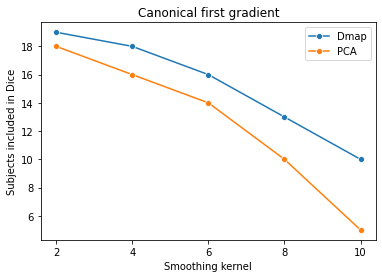

In [9]:
##### get rejects
pc_reject=[]
dm_reject=[]

dm_dirtySubj=[]
pc_dirtySubj=[]
kernels=[2,4,6,8,10]
for k in kernels:
    
    a=prep_plotsXkernel(k)
    dm_reject.append(len(subjects)-len(a[8]))
    dm_dirtySubj.append(a[8])
    
    b=prep_plotsXkernel(k,pca=True)
    pc_reject.append(len(subjects)-len(b[8]))
    pc_dirtySubj.append(b[8])
    
dm_reject=np.asarray(dm_reject)
pc_reject=np.asarray(pc_reject)

# sn.set()
g=sn.lineplot(x=kernels,y=dm_reject,markers=True, dashes=True,marker='o',label='Dmap')
g=sn.lineplot(x=kernels,y=pc_reject,markers=True, dashes=True,marker='o',label='PCA')
g.set_xticks(kernels)
g.set_xlabel('Smoothing kernel')
g.set_ylabel('Subjects included in Dice')
g.set_title('Canonical first gradient')
plt.savefig('subjects_perkernel.png',facecolor='w')

Look at that. Depending on the level of smoothing and the decomposition algorithm used, we see that the number of subjects which outputs the uni-to-transmodal gradient changes. We'll take this into account when comparing the overlap as calculated by the dice scores in the next section

But first a quick set up cell

In [10]:
### set up color palletes and thresholds
thr=[50,55,60,65,70,75,80,85,90,95]
pal = sn.color_palette(palette='Set2',n_colors=10)
### set up the dictionaries so we can plot them with hue's in seaborn 
regions={}
regions['Left Hemisphere']=0
regions['Right Hemisphere']=1
regions['Left Lateral Parietal']=2
regions['Left Temporal']=3
regions['Left Medial Parietal']=4
regions['Right Lateral Parietal']=5
regions['Right Temporal']=6
regions['Right Medial Parietal']=7

kernels=[2, 4, 6, 8, 10]

#### The peak is considered as the intersect between the top X percent of session 1 and session 2's respective gradients. 
- We calculate the Dice Sorensen Coefficient to show how overlap changes as a function of smoothing and thresholding. 
    - We correct the Dice score by multiplying it by the fraction of subjects where the principal gradient corresponds to the first gradient out of the whole group

## How do peaks change as a result of smoothing?

In [ ]:
##### plot dice scores corrected for number of subjects from group 
for key in regions:
    f, ax = plt.subplots(ncols=5,nrows=1,figsize=(16,6))
    plt.subplot(151)
    plot_itHue(2,regions[key])
    plt.subplot(152)
    plot_itHue(4,regions[key])
    plt.subplot(153)
    plot_itHue(6,regions[key])
    plt.gca().set_title(key,fontsize = 20)
    plt.subplot(154)
    plot_itHue(8,regions[key])
    plt.subplot(155)
    plot_itHue(10,regions[key],legend=True)
    
    plt.savefig(f'../Dice_overlap/{key}_corr.png',facecolor='w')
    

The above cell takes the dice scores across global gradient thresholds and presents them as multiplied by the fraction of subjects with the canonical gradient as the first gradient. For example at smoothing = 10 mm the Diffusion map dice score is multipled by 10/20 and the PCA dice score is multiplied by 5/20.

The results here suggest that for the left and right hemisphere as well as in zone specific regions diffusion mapping tends to be more reliable, in large part because it better preserves the gradient order

This method assures that we take into account gradient order as part of the reproducibility across subjects. 

To see the results with no correction, run the following cell. 

In [ ]:
##### plot dice scores uncorrected for number of subjects left in group 
for key in regions:
    f, ax = plt.subplots(ncols=5,nrows=1,figsize=(16,6))
    plt.subplot(151)
    plot_itHue(2,regions[key],corr=False)
    plt.subplot(152)
    plot_itHue(4,regions[key],corr=False)
    plt.subplot(153)
    plot_itHue(6,regions[key],corr=False)
    plt.gca().set_title(key,fontsize = 20)
    plt.subplot(154)
    plot_itHue(8,regions[key],corr=False)
    plt.subplot(155)
    plot_itHue(10,regions[key],corr=False,legend=True)
    
    plt.savefig(f'../Dice_overlap/{key}_uncorr.png',facecolor='w')
    

Based on the results of this analysis we'll use gradients derived from diffusion map embedding and a smoothing kernel of 6 mm.This decision is based on observing the trade-off in preserving gradient order across subjects, and maintaining relatively high dice scores as well.

While it is tempting to conclude from the uncorrected dice scores that we should use PCA, remember that for example in the 10mm smoothing, PCA is using half the subjects. While this might be a reaosn to consider PCA as our method in the future, we currently only have 20 subjects total and thus want to maximize the gradients we do have.



### Defining peaks

To define the peaks we use the hcp_subj class function get_peaks_postZones(thr) where thr is the global threshold applied to Session 1 and Session 2 principal gradients

To use this function the hcp_subj class must be inititated with the <neighbours=True> parameter. 

Peaks are defined as follows:
1. Threshold the gradient from session 1 and session 2
2. Calculate the intercept of the thresheld gradients
    - Binarize it
3. Extract the intercept mask for each zone 
    - Lateral Parietal, Lateral Temporal, Medial Parietal
4. Within each zone take the largest connected component 
    - i.e make sure peak is contiguous

###### Let's get a list of our clean subjects at 6mm then

In [11]:
mm6_dirt=dm_dirtySubj[2] #### get the dirty sbjects from 6mm
dm_dirtySubj=set(flatten(dm_dirtySubj))
pc_dirtySubj=set(flatten(pc_dirtySubj))
clean_6mm=list(set(subjects).difference(mm6_dirt))
clean_dm=list(set(subjects).difference(dm_dirtySubj))
clean_pc=list(set(subjects).difference(pc_dirtySubj))

### Visualizing peaks across thresholds. 

**The neighbours argument takes longer to generate the class as it creates a full list of neighbours for an individuals surface files.**  
   - We limit it's use making a dictionary from which we can reference the stored classes for each subject

In [ ]:
from tqdm import tqdm

In [ ]:
sub_dict={}
for i in tqdm(range(len(clean_6mm))):
    sub_dict[clean_6mm[i]]=hcp_subj(clean_6mm[i],6,neighbours=True)

**We can use this dictionary to extract and plot peaks for distance measuremeants**
- Peak evolution across thresholds looks like this:

 <img src="peak_refinement100307.gif" alt="Peaks" style="width: 400px;"/>

To generate the above figure uncomment and run the cell below. Change the subject ID to run it on another subject

In [ ]:
# for i in range(70,100,2):
#     sub_dict['100307'].get_peaks_postZones(i,visualize='git')
#     plt.savefig(f'gif_thr/sub100307thr00{i}.png',facecolor='w',bbox_inches='tight')
# !convert -delay 100 -loop 0 gif_thr/*.png peak_refinement100307.gif

# Hypothesis
## There is a relative position encoded by distance from primary cortex that places transmodal cortex where it is

**Can this be used to form a relative positioning or coordinate system?**
- If this is the case then 
    - As the gradient threshold goes up making the peaks shrink:
        - Then the minimum distance of a transmodal peak to sensory cortex should also go up 
        - Do peaks move along the same axes across individuals? 
            - An axis defined by distance from primary cortex?
        

First measure the distance of each peak to the rest of the cortex

In [ ]:
###############################
###############################
###############################
#WHY NOT JUST SET UP THE DISTANCE MEASURES HERE AND DO THEM ALL AT ONCE? 
# SAVE A VALUE NOT A VECTOR. NO MEMORY PROBLEMS
###############################
###############################
###############################

In [ ]:
containL=[]
containR=[]
for thr in tqdm(range(80,100,2)):
    thr_distL={}
    thr_distR={}

    for key in sub_dict:
        dat=sub_dict[key]
        

        L,R=dat.get_peaks_postZones(thr)
        
        #### set up left cortex for distance measurements
        ctxL=dat.Lfill #np.where(nib.load(dat.Laparc).darrays[0].data!=0)[0]
        ### set up surface
        srfL=[dat.Lcoords,dat.Lfaces]
        
          #### set up left cortex for distance measurements
        ctxR=dat.Rfill #np.where(nib.load(dat.Laparc).darrays[0].data!=0)[0]
        ### set up surface
        srfR=[dat.Rcoords,dat.Rfaces]
        
        
        distancesL=[]
        #### SET UP V1,S1,A1 HERE??????
        
        for peak in range(len(L)):
            if np.isnan(L[peak][0]).any()==True:
                distancesL.append(np.nan)
            else:
                dist=surfdist.analysis.dist_calc(srfL,ctxL,L[peak])
                dist[np.where(np.isfinite(dist)==False)[0]]=0
                distancesL.append(dist)
                del dist
        if len(distancesL)==3:
            distancesL.append(surfdist.analysis.dist_calc(srfL,ctxL,dat.get_fullThrIntersect(thr)[0]))
     
        thr_distL[key]=distancesL
        del distancesL
            
        
        distancesR=[]
        for peak in range(len(R)):
            if np.isnan(R[peak][0]).any()==True:
                distancesR.append(np.nan)
            else:
                dist=surfdist.analysis.dist_calc(srfR,ctxR,R[peak])
                dist[np.where(np.isfinite(dist)==False)[0]]=0
                distancesR.append(dist)
                del dist
        if len(distancesR)==3:
            distancesR.append(surfdist.analysis.dist_calc(srfL,ctxL,dat.get_fullThrIntersect(thr)[1]))
     
        thr_distR[key]=distancesR
        del distancesR
        
        
        
    containL.append(thr_distL)
    containR.append(thr_distR)

We've calculated the distances from the peaks to the rest of the cortex from 70-98 in increments of 2. That's a lot of distances! We keep all of these distances in a list which we call "contain." Each index of the "contain" list contains a dictionary of each subjects distances from peaks to cortex. If the medial parietal is included than there are 3 distances. otherwise there is a single nan returned

#### First we define a couple of helper functions
1. The first takes sensory regions of interest for each subject
    - V1, S1, A1
2. The second extracts the distance form the peaks for each region 

In [ ]:
def get_sensROIS(subID,hemi):
    if hemi =='R':
        V1=sub_dict[subID].RV1
        S1=sub_dict[subID].RS1
        A1=sub_dict[subID].RA1 
    elif hemi =='L':
        V1=sub_dict[subID].LV1
        S1=sub_dict[subID].LS1
        A1=sub_dict[subID].LA1

    return V1,S1,A1

In [ ]:
def get_sens2pk(data,hemi):
    #### add a hemi argument to specify left and right ROIs
    #### set up sensory lists. we've got 9 measures per subjectper hemisphere... 
    parV1=[]
    parS1=[]
    parA1=[]
        
    tmpV1=[]
    tmpS1=[]
    tmpA1=[]
    
    mparV1=[]
    mparS1=[]
    mparA1=[]

    
    x=0 
    
    for key in data:
        
        V1,S1,A1=get_sensROIS(key,hemi)

        if np.isnan(data[key][0]).any()==False: 
            parV1.append(np.min(data[key][0][V1])) 
            parS1.append(np.min(data[key][0][S1])) 
            parA1.append(np.min(data[key][0][A1]))
        else:
            parV1.append(np.nan) 
            parS1.append(np.nan) 
            parA1.append(np.nan)
                
        if np.isnan(data[key][1]).any()==False: 
            tmpV1.append(np.min(data[key][1][V1])) 
            tmpS1.append(np.min(data[key][1][S1])) 
            tmpA1.append(np.min(data[key][1][A1]))
        else:
            tmpV1.append(np.nan) 
            tmpS1.append(np.nan) 
            tmpA1.append(np.nan)
            
            
        if np.isnan(data[key][2]).any()==False: 
            mparV1.append(np.min(data[key][2][V1])) 
            mparS1.append(np.min(data[key][2][S1])) 
            mparA1.append(np.min(data[key][2][A1]))
        else:
            mparV1.append(np.nan) 
            mparS1.append(np.nan) 
            mparA1.append(np.nan)
                
    return [parV1,parS1,parA1],[tmpV1,tmpS1,tmpA1],[mparV1,mparS1,mparA1]
            
            

            


In [ ]:
############### 
#### DO FOR ALL REGIONS IN ATLAS. 
#### THEN WE CAN RANK THEM AS HOW FAR AWAY THEY ARE FROM CERTAIN REGIONS. 


Now we'll put it all together to prep for plotting

In [ ]:
def prep_sens2pkSubjPlots(hemi):
    """ Specify hemisphere as 'L' or 'R' """
    lParV1=[]
    lParS1=[]
    lParA1=[]
    lTmpV1=[]
    lTmpS1=[]
    lTmpA1=[]
    mParV1=[]
    mParS1=[]
    mParA1=[]

    for i in containL:
        #lateral parietal
        lParV1.append(get_sens2pk(i,hemi)[0][0])
        lParS1.append(get_sens2pk(i,hemi)[0][1])
        lParA1.append(get_sens2pk(i,hemi)[0][2])
    
        #lateral temporal
        lTmpV1.append(get_sens2pk(i,hemi)[1][0])
        lTmpS1.append(get_sens2pk(i,hemi)[1][1])
        lTmpA1.append(get_sens2pk(i,hemi)[1][2])
        
        #medial parietal
        mParV1.append(get_sens2pk(i,hemi)[2][0])
        mParS1.append(get_sens2pk(i,hemi)[2][1])
        mParA1.append(get_sens2pk(i,hemi)[2][2])
    
    to_dict=[lParV1,lParS1,lParA1,lTmpV1,lTmpS1,lTmpA1,mParV1,mParS1,mParA1]

    for i in range(len(to_dict)):
        to_dict[i]=dict(zip(sub_dict.keys(),np.vstack(to_dict[i]).T))
    return to_dict

In [ ]:
def plot_subjectwiseDist(dic,title):
    ticks=list(range(80,100,2))
#     dic=pd.DataFrame.from_dict(dic)
    ax=sn.lineplot(data=dic,marker='o')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xticks(range(10))
    ax.set_xticklabels(ticks)
    plt.ylabel('Distance')
    plt.xlabel('Gradient Threshold')
    plt.title(title)

### Plotting distance to the peak as the gradient threshold is increased


The above function creates a dictionary where the distance from the peak to sensory regions is contained across the range of thresholds specified. In this case it's from 80-98 in increments of 2. 

**Will we see that moving up the gradient moves us further from sensory cortex on the individual level?**

In [ ]:
#### first get rid of an outlier. I know it's an outlier because I've already run this... 
L=prep_sens2pkSubjPlots('L')
for i in L:
    del i['101006']
    del i['102311'] #### this one is only an outlier on the medial parietal to SMN. but I want this to be pretty today

#### first get rid of an outlier. I know it's an outlier because I've already run this... 
R=prep_sens2pkSubjPlots('R')
for i in R:
    del i['101006']
    del i['102311'] #### this one is only an outlier on the medial parietal to SMN. but I want this to be pretty today
    

#### Lateral parietal peak distance from sensory regions

In [ ]:
!pwd

In [ ]:
fig = plt.gcf()
fig.set_size_inches(15,5)
plt.subplot(131)
plot_subjectwiseDist(L[0],'V1')
plt.subplot(132)
plot_subjectwiseDist(L[1],'S1')
plt.subplot(133)
plot_subjectwiseDist(L[2],'A1')
plt.suptitle('Left Lateral Parietal Peak')
plt.tight_layout()
plt.savefig('LlatParPk_2sensSubj.png',facecolor='w')

In [ ]:
fig = plt.gcf()
fig.set_size_inches(15,5)
plt.subplot(131)
plot_subjectwiseDist(R[0],'V1')
plt.subplot(132)
plot_subjectwiseDist(R[1],'S1')
plt.subplot(133)
plot_subjectwiseDist(R[2],'A1')
plt.suptitle('Right Lateral Parietal Peak')
plt.tight_layout()
plt.savefig('RlatParPk_2sensSubj.png',facecolor='w')

#### Medial parietal peak distance from sensory regions

In [ ]:
fig = plt.gcf()
fig.set_size_inches(15,5)
plt.subplot(131)
plot_subjectwiseDist(L[6],'V1')
plt.subplot(132)
plot_subjectwiseDist(L[7],'S1')
plt.subplot(133)
plot_subjectwiseDist(L[8],'A1')
plt.suptitle('Left Medial Parietal Peak')
plt.tight_layout()
plt.savefig('LmedParPk_2sensSubj.png',facecolor='w')

In [ ]:
fig = plt.gcf()
fig.set_size_inches(15,5)
plt.subplot(131)
plot_subjectwiseDist(R[6],'V1')
plt.subplot(132)
plot_subjectwiseDist(R[7],'S1')
plt.subplot(133)
plot_subjectwiseDist(R[8],'A1')
plt.suptitle('Right Medial Parietal Peak')
plt.tight_layout()
plt.savefig('RmedParPk_2sensSubj.png',facecolor='w')

#### Lateral temporal peak distance from sensory regions

In [ ]:
fig = plt.gcf()
fig.set_size_inches(15,5)
plt.subplot(131)
plot_subjectwiseDist(L[4],'V1')
plt.subplot(132)
plot_subjectwiseDist(L[5],'S1')
plt.subplot(133)
plot_subjectwiseDist(L[6],'A1')
plt.suptitle('Left Lateral Temporal Peak')
plt.tight_layout()
plt.savefig('LtmpParPk_2sensSubj.png',facecolor='w')

In [ ]:
fig = plt.gcf()
fig.set_size_inches(15,5)
plt.subplot(131)
plot_subjectwiseDist(R[4],'V1')
plt.subplot(132)
plot_subjectwiseDist(R[5],'S1')
plt.subplot(133)
plot_subjectwiseDist(R[6],'A1')
plt.suptitle('Right Lateral Temporal Peak')
plt.tight_layout()
plt.savefig('RtmpParPk_2sensSubj.png',facecolor='w')

### As peaks get smaller they move away from primary cortex

As we go up the gradient, refining the peaks, we show that across individuals the peaks are moving further and further from primary cortex. 

Let's look at it the other way and show how peaks move away from all sensory cortex as we apply higher and higher thresholds. 

*But first we'll clear some memory*

In [ ]:
# del containL
# del containR
# del thr_distL
# del thr_distR

In [ ]:
def plot_pk2sens(hemi):
    out=[]
    for key in sub_dict:
        
        if hemi =='L':
            metric=sub_dict[key].LdistSens
    
            thr_dists=[]
            for thr in range(80,100,2):
                L,R=dat.get_peaks_postZones(thr)
        
                distances=[]
                for peak in range(len(L)):
                    if np.isnan(L[peak][0]).any()==True:
                        distances.append(np.nan)
                    else:
                        dist=np.nanmin(metric[L[peak]])
                        distances.append(dist)
                thr_dists.append(np.hstack(distances))
            out.append(thr_dists)
            
        if hemi =='R':
            metric=sub_dict[key].RdistSens
    
            thr_dists=[]
            for thr in range(80,100,2):
                L,R=dat.get_peaks_postZones(thr)
        
                distances=[]
                for peak in range(len(R)):
                    if np.isnan(R[peak][0]).any()==True:
                        distances.append(np.nan)
                    else:
                        dist=np.nanmin(metric[R[peak]])
                        distances.append(dist)
                thr_dists.append(np.hstack(distances))
            out.append(thr_dists)
            
    tst=dict(zip(sub_dict.keys(),out))
    latPar={}
    latTmp={}
    medPar={}
    for key in tst:
        lpar=np.vstack(tst[key])[:,0]
        latPar[key]=lpar
        ltmp=np.vstack(tst[key])[:,1]
        latTmp[key]=ltmp
        mpar=np.vstack(tst[key])[:,2]
        medPar[key]=mpar
    return latPar,latTmp,medPar

In [ ]:
LlatPar,LlatTmp,LmedPar=plot_pk2sens('L')

In [ ]:
RlatPar,RlatTmp,RmedPar=plot_pk2sens('R')

In [ ]:
fig = plt.gcf()
fig.set_size_inches(15,5)
plt.subplot(131)
plot_subjectwiseDist(LlatPar,'Lateral Parietal')
plt.subplot(132)
plot_subjectwiseDist(LlatTmp,'Medial Parietal')
plt.subplot(133)
plot_subjectwiseDist(LmedPar,'Lateral Temporal')
plt.suptitle('Left Peaks to sensory cortex')
plt.tight_layout()
plt.savefig('Lpeaks2sens.png',facecolor='w')

In [ ]:
fig = plt.gcf()
fig.set_size_inches(15,5)
plt.subplot(131)
plot_subjectwiseDist(RlatPar,'Lateral Parietal')
plt.subplot(132)
plot_subjectwiseDist(RlatTmp,'Medial Parietal')
plt.subplot(133)
plot_subjectwiseDist(RmedPar,'Lateral Temporal')
plt.suptitle('Right Peaks to sensory cortex')
plt.tight_layout()
plt.savefig('Rpeaks2sens.png',facecolor='w')

## Way too preliminary conclusions

As we move up the gradient we are also moving the peak further away from primary anchors. We're seeing this on an individual level, and moreover this data is uncorrected for brain size. I imagine if we correct thhen the dispersion of these lines may move together. However, the *important observation is that* ***across subjects the slopes are positive across all measures***

**What's next?**

The slope at which the peak moves away from the sensory cortex is quite interesting as a metric, and I wonder if it's meaningful in anyway. I would love to test this on a large cohort od subjects and then look if there might be behavioral measures that could be correlated to the rate at which a peak moves away from the sensory cortex. If it suggests something meaningful than the next step would likely to look at clinical populaitons where they talk about a "compressed" gradient, but don't realy describe it. If this holds up we potentially could show how this changes at in individual level.

## If  related to distance from sensory than the slope will change more for the sensory regions than for other regions. show with atlases?

In [ ]:
import hcp_utils as hcp
from matplotlib.colors import rgb2hex

In [ ]:
yeo_left=hcp.left_cortex_data(hcp.yeo7['map_all'][hcp.struct.cortex_left])
yeo_right=hcp.right_cortex_data(hcp.yeo7['map_all'][hcp.struct.cortex_right])

In [ ]:
def force_df(dictionary):
    return pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in dictionary.items() ]))

In [ ]:
def get_parcels(prc):
    prc_file=nib.load(prc)
    prc=prc_file.labeltable.get_labels_as_dict()
    parcels={}
    for key in prc:
        parcels[prc[key]]=(np.where(prc_file.darrays[0].data==key)[0])
    del parcels['???']
    return parcels
        

In [ ]:
ex_sub=clean_6mm[11]

In [ ]:
tst=hcp_subj(ex_sub,6)

In [ ]:
lb=get_parcels(tst.Laparc)

In [ ]:
from statistics import mode

In [ ]:
yeo_dictL={}
for key in lb:
    if key == 'L_Medial_wall':
        pass
    else:
        yeo_dictL[key]=mode(yeo_left[lb[key]])

In [ ]:
custom=hcp.yeo7['rgba'].copy()
for key in custom:
    custom[key]=rgb2hex(custom[key])

In [ ]:
for key in yeo_dictL:
    yeo_dictL[key]=hcp.yeo7['labels'][yeo_dictL[key]]
    

In [ ]:
network_labels=hcp.yeo7['labels'].copy()

In [ ]:
custom2={}
for key in network_labels:
    custom2[network_labels[key]]=custom[key]
    

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
custom=custom2.copy()
del custom2

In [ ]:
x=0
for i in range(80,100,2):
    print(x,i)
    x=x+1

In [ ]:

metric80=containL[2][ex_sub][3]
metric88=containL[5][ex_sub][3]
metric90=containL[7][ex_sub][3]
thr80={}
thr88={}
thr90={}
for key in lb:
    thr80[key]=metric80[lb[key]]
    thr88[key]=metric88[lb[key]]
    thr90[key]=metric90[lb[key]]

In [ ]:
np.warnings.filterwarnings('ignore')

In [ ]:
def box_plot_parcelsXsub(data,plot=True):
    data=force_df(data)
#     data.drop(columns='L_Medial_wall',inplace=True)
    for key in data:
        subset=data[key].dropna()
        num=np.sum(subset==0)
        den=subset.shape
        if num==1:
#             data[key]<0.01=np.nan
            data.loc[data[key]<0.01]=np.nan
            print(key)
    
    
    re_order=list(data.mean().sort_values(ascending=True).keys())
    data=data[re_order]
#     data=data.min().to_frame().T
    labels=list(data.columns)
    melted=data.melt()
#     melted['Primary Cortex']=0
    for key in yeo_dictL:
         melted.loc[melted['variable']==key,'Primary Cortex']=yeo_dictL[key]
    
    melted.loc[melted['variable']=='L_S_calcarine','Primary Cortex']='V1'
    melted.loc[melted['variable']=='L_S_central','Primary Cortex']='S1'
    melted.loc[melted['variable']=='L_S_temporal_transverse','Primary Cortex']='A1'
    

#     custom=hcp.yeo7['rgba']
#     for key in custom:
#         custom[key]=rgb2hex(custom[key])

    custom['V1']='#FF5733'
    custom['A1']='#77F1E1'
    custom['S1']='#09ed05'
    
    if plot==True:
        fig = plt.gcf()
        fig.set_size_inches(15,10)
#         pal =sn.color_palette(custom.values())
        ax=sn.boxplot(data=melted,x='variable',y='value',hue='Primary Cortex',palette=custom,dodge=False)
        sn.despine(offset=0, trim=True);
        ax.set_xticklabels(labels,rotation = 90,size=10)
        ax.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
        plt.tight_layout()
    
    
    return data,melted,re_order
    
    

In [ ]:
!pwd

In [ ]:
a,b,c=box_plot_parcelsXsub(thr80)
plt.savefig('multiparcel84.png',facecolor='w',bbox_inches='tight')

In [ ]:
a,b,c=box_plot_parcelsXsub(thr88)

In [ ]:
a,b,c=box_plot_parcelsXsub(thr90)
plt.savefig('multiparcel94.png',facecolor='w',bbox_inches='tight')

# Implement a slope a cross thresholds for different parcels. play with min and mean... 

In [ ]:
lparDf={}
ltmpDf={}
mparDf={}
grdDf={}

for key in clean_6mm:
    lpar=[]
    ltmp=[]
    mpar=[]
    grd=[]
    for threshed in containL:
        lpar.append(threshed[key][0])
        ltmp.append(threshed[key][1])
        mpar.append(threshed[key][2])
        grd.append(threshed[key][3])
    lparDf[key]=lpar
    ltmpDf[key]=ltmp
    mparDf[key]=mpar
    grdDf[key]=grd
lparDf=force_df(lparDf)
ltmpDf=force_df(ltmpDf)
mparDf=force_df(mparDf)
grdDf=force_df(grdDf)



In [ ]:
maximax=[]
for i in grdDf[ex_sub]:
    maximax.append(np.max(i))
maximax=np.hstack(maximax)

In [ ]:
sn.lineplot(data=maximax)

In [ ]:
maximax[-1]-maximax[0]

In [ ]:
#### remove lone zeros 
def quitaZeros(data):
    for key in data:
        subset=data[key].dropna()
        num=np.sum(subset==0)
        den=subset.shape
        if num==1:
            data.loc[data[key]<0.01]=np.nan
    return data

In [ ]:
ex_sub

In [ ]:
############ change data frame here to diff regions
parcels=get_parcels(sub_dict[ex_sub].Laparc)
dfs=[]
for i in grdDf[ex_sub]:
    if np.isnan(i).any()==True:
        pass
    else:
        dat={}
        for j in parcels:
            dat[j]=i[parcels[j]]
        del dat['L_Medial_wall']
        dfs.append(quitaZeros(force_df(dat)))

In [ ]:
for i in range(len(dfs)):
    dfs[i]=dfs[i].min().to_frame().T

In [ ]:
huh=pd.concat(dfs)


In [ ]:
huh=huh.diff()

In [ ]:
sub_dict[ex_sub].plot_ThrIntersectCortex(90)

In [ ]:
huh['L_S_calcarine']

In [ ]:
huh['L_S_temporal_transverse']

In [ ]:
# huh=huh.iloc[-1]-huh.iloc[-4].to_frame().T

In [ ]:
re_order=list(huh.mean().sort_values(ascending=True).keys())
huh=huh[re_order]

In [ ]:
def applyNetworkHue(df):
    labels=list(df.columns)
    melted=df.melt()
#     melted['Primary Cortex']=0
    for label in labels:
         melted.loc[melted['variable']==label,'Primary Cortex']=yeo_dictL[label]
    
    melted.loc[melted['variable']=='L_S_calcarine','Primary Cortex']='V1'
    melted.loc[melted['variable']=='L_S_central','Primary Cortex']='S1'
    melted.loc[melted['variable']=='L_S_temporal_transverse','Primary Cortex']='A1'
    
    return melted
    

In [ ]:
huh=applyNetworkHue(huh)

In [ ]:
fig = plt.gcf()
fig.set_size_inches(15,10)
ax=sn.boxplot(data=huh,x='variable',y='value',hue='Primary Cortex',palette=custom,dodge=False)
sn.despine(offset=0, trim=True);
ax.set_xticklabels(re_order,rotation = 90,size=12)
ax.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0)
plt.tight_layout()

In [ ]:
huh[huh['Primary Cortex']=='Visual']

In [ ]:
def region_dist(dat,thr):
    a=force_df(dat)
#     a=pd.DataFrame(a)
#     a.reset_index(inplace=True)
#     a.reset_index(inplace=True)
#     a.set_index('index',inplace=True)
#     a.rename(columns={'level_0':f'order {thr}'},inplace=True) 
#     a.rename(columns={0:f'dist {thr}'},inplace=True)
#     a.drop('L_Medial_wall',inplace=True)
#     a=a.T
    return a

In [ ]:
def region_order(dat,thr):
    a=force_df(dat).mean().sort_values()
    a=pd.DataFrame(a)
    a.reset_index(inplace=True)
    a.reset_index(inplace=True)
    a.set_index('index',inplace=True)
    a.rename(columns={'level_0':f'order {thr}'},inplace=True) 
    a.rename(columns={0:f'dist {thr}'},inplace=True)
    a.drop('L_Medial_wall',inplace=True)
    a=a.T
    return a

In [ ]:
a=region_dist(thr90,90)

In [ ]:
a=region_order(thr90,90)
b=region_order(thr88,88)
c=region_order(thr80,80)

In [ ]:
joi=pd.merge(a.T, b.T, left_index=True, right_index=True)
joi=pd.merge(joi,c.T,left_index=True, right_index=True)

In [ ]:
joi=joi.T

In [ ]:
joi['L_S_calcarine']

In [ ]:
joi['L_S_central']

In [ ]:
joi['L_S_temporal_transverse']

In [ ]:
b=force_df(thr80).mean().sort_values()
# b1=dict(zip(b[0],b[1]))

In [ ]:
b.to_frame().reset_index()

In [ ]:
value = set(b) - set(a)

In [ ]:
parcels={}
for key in tst.labeltable.get_labels_as_dict():
    parcels[tst.labeltable.get_labels_as_dict()[key]]=(np.where(tst.darrays[0].data==key)[0])
del parcels['???']
# del latPar['L_Medial_wall']

In [ ]:
dists=containL[0]['102715']

In [ ]:
means=[]
for i in range(len(containL)):
    dists=containL[i]['102715'][0]
    latPar={}
    for key in parcels:
        print(key)
        print(parcels[key])
        latPar[key]=dists[parcels[key]]
#     latPar=pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in latPar.items() ]))
#     meanish=latPar.mean()
#     means.append(meanish)
        

In [ ]:
tst=pd.DataFrame.from_dict(means)

In [ ]:
ok=tst.iloc[-4]-tst.iloc[0]

In [ ]:
ok.sort_values(inplace=True)

In [ ]:
ok=ok.drop(['L_Medial_wall'])


In [ ]:
latPar={}
for key in parcels:
    latPar[key]=dists[0][parcels[key]]
latPar=pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in latPar.items() ]))

In [ ]:
##### make a data frame from a dictionary where not all arrays have same length


In [ ]:
tst=latPar.min()


In [ ]:
tst

In [ ]:
sorty=list(tst.sort_values().keys())

In [ ]:
dat=latPar.T.reindex(sorty).T

In [ ]:
dat.drop(columns=['L_Medial_wall'],inplace=True)

In [ ]:
# dat

In [ ]:
fig = plt.gcf()
fig.set_size_inches(20,10)
ax=sn.boxplot(data=dat)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90,size=12)
plt.tight_layout()
plt.savefig('/Users/austin/Desktop/test.png',facecolor='w')

In [ ]:
group=nib.load('../../hcp.embed.L.func.gii').darrays[0].data

In [ ]:
G1=group[np.where(group!=0)[0]]
ctx=np.where(group!=0)[0]


In [ ]:
np.percentile(G1,90)

In [ ]:
thrs=[]
x=0
for i in range(40,100,2):
    print(x,i)
    x=x+1
    cut=np.percentile(G1,i)
    group_thr=np.where(G1>cut)[0]
    mini=np.zeros(len(ctx))
    mini[group_thr]=1
    out=np.zeros(len(group))
    out[ctx]=mini
    thrs.append(out)

In [ ]:
nilearn.plotting.view_surf(tst.Linflated,thrs[20],symmetric_cmap=False,cmap='viridis')

In [12]:
tst=hcp_subj(clean_6mm[0],6,neighbours=True)

In [21]:
datum=np.floor(tst.LdistSens)
datum[datum>45]=0
datum[datum<45]=0

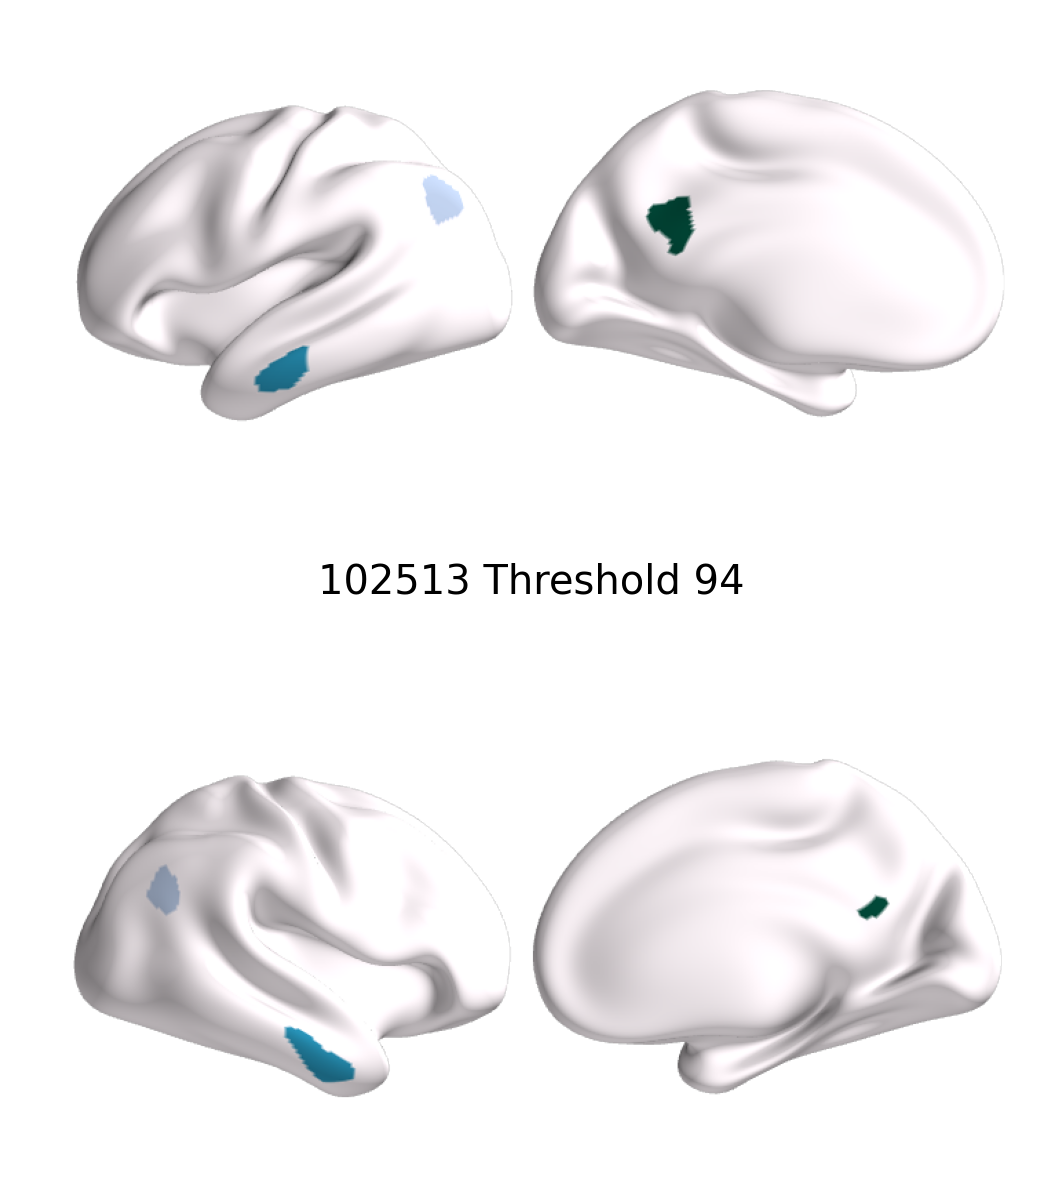

In [22]:
a,b=tst.get_peaks_postZones(94,visualize=True)

In [23]:
nilearn.plotting.view_surf(tst.Linflated,datum,cmap='viridis')

In [ ]:
a,b=oh_mayavi(tst.Lsrf,datum,cmap='coolwarm')

In [ ]:
plt.imshow(a)